# Jigsaw - Agile Community Rules Classification
### https://www.kaggle.com/competitions/jigsaw-agile-community-rules

## Constrained Generation for Reddit Content Moderation: Binary Classification Using Logit Probabilities
Technical Overview
This notebook implements a constrained generation approach for automated content moderation using a Llama 3.2-1B model. Instead of relying on traditional text parsing, we employ logits processors to restrict the model's output vocabulary to only "True" and "False" tokens, then extract probabilistic confidence scores directly from the model's logit distributions.
A reference notebook from  https://www.kaggle.com/code/xbar19/jigsaw-llama3-1-8b-instruct-fine-tuned is appreciated.

## Install packages on Kaggle: Add-ons > Install Dependencies 

```bash
pip install pip3-autoremove
pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu124
pip install unsloth vllm
pip install scikit-learn
```

In [1]:
import kagglehub
import pandas as pd
import os
import glob
import pandas as pd

# Your path and files
base_path = "./data/final/"
files = ["df_test_cr_12.csv"]  # Put your file names here

# Load and combine
dfs = [pd.read_csv(f"{base_path}{file}") for file in files]
df_test = pd.concat(dfs, ignore_index=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)
#df_test['violates_rule_yn'] = df_test['violates_rule'].map({True: "Yes", False: "No"})
print(f"Combined shape: {df_test.shape}")

df_test.head(10)

#df_test=df_test[:100]

Combined shape: (2000, 8)


,subreddit,rule,positive_example_1,negative_example_1,positive_example_2,negative_example_2,test_comment,violates_rule
0,funny,"No Advertising: Spam, referral links, unsolici...","""Just found this amazing site that gives you F...","""This is exactly what my dog does when I try t...","""My cousin just launched his new comedy podcas...","""My grandma just discovered memes and sent me ...","""When you're trying to be sneaky eating the la...",No
1,OldSchoolCool,no promotion of illegal activity: do not encou...,"""That vintage car is so clean you could totall...","""My grandpa used to tell stories about how the...","""If you find old photos like these in an estat...","""This photo reminds me of my uncle's stories a...","""Back in the 70s my dad had that exact jacket!...",No
2,philosophy,no promotion of illegal activity: do not encou...,Honestly if corporations are stealing our data...,While civil disobedience has philosophical roo...,The government has made psychedelics illegal b...,The ethical dilemma of whistleblowing presents...,"From a virtue ethics perspective, the prohibit...",No
3,askscience,no medical advice: do not offer or request spe...,My doctor prescribed me 500mg of amoxicillin t...,Can someone explain the biochemical mechanism ...,I've had this weird rash on my arm for two wee...,What's the current scientific consensus on the...,My friend has been experiencing chest pain and...,Yes
4,askscience,no promotion of illegal activity: do not encou...,"""Just synthesize it yourself bro, the precurso...","""Theoretical question: if someone were to hypo...","""If your PI is stealing your work, just hack t...","""This paper discusses the pharmacological effe...","""You don't need a prescription for those antib...",Yes
5,AskTrumpSupporters,"No Advertising: Spam, referral links, unsolici...","Hey folks, I've been making serious money with...",I think the mainstream media deliberately misr...,"If you're tired of biased media, check out my ...",The border situation would improve dramaticall...,"Honestly, the economic policies during Trump's...",No
6,fantasyfootball,"No Advertising: Spam, referral links, unsolici...",Just found this amazing fantasy tool at Fantas...,My buddy's terrible take that Josh Allen would...,"Hey everyone, I run a paid Discord server with...",Anyone else's league have that one manager who...,Check out my new fantasy football YouTube chan...,Yes
7,nba,no medical advice: do not offer or request spe...,"""For that ankle sprain, you need to get on 800...","""Man, seeing KD limp off the court like that b...","""Anyone know what specific medication LeBron t...","""The way Giannis plays through pain is insane....","""That concussion looks serious - you should tr...",Yes
8,gonewild,no promotion of illegal activity: do not encou...,Honestly if you're posting nudes online you sh...,I can't believe some people actually think it'...,If someone leaks your content just dox them ba...,Getting so many requests for meetups but I'm s...,The number of guys asking me to roleplay as un...,No
9,explainlikeimfive,no financial advice: we do not permit comments...,You should definitely put all your savings int...,Compound interest is basically when your money...,"Don't bother with a 401k, just day trade meme ...",The stock market works like an auction house w...,Inflation happens when there's too much money ...,No


## Load LLM (llama-3.2-1B) model with vLLM (Suitable for batch inference) (logits output)

In [2]:
import multiprocessing as mp
mp.set_start_method('spawn', force=True)
import os
os.environ['VLLM_USE_V1'] = '0'  # Force V0 for logits processor support

import torch
import numpy as np
import pandas as pd
from vllm import LLM, SamplingParams
from transformers import LogitsProcessor
import math
from vllm.lora.request import LoRARequest


class YesNoLogitsProcessor(LogitsProcessor):
    """Forces model to only output Yes or No tokens"""
    def __init__(self, allowed_ids):
        self.allowed_ids = allowed_ids
        
    def __call__(self, input_ids, scores: torch.Tensor) -> torch.Tensor:
        # Create a mask that's -inf for all tokens except allowed ones
        mask = torch.full_like(scores, float('-inf'))
        mask[self.allowed_ids] = 0
        
        # Apply the mask to force only allowed tokens
        scores = scores + mask
        return scores



class LlamaClassifier:
    def __init__(self):
        # Model path selection
        if os.getenv('KAGGLE_KERNEL_RUN_TYPE'):
            self.model_path = "/kaggle/input/qwen2.5/transformers/14b-instruct-gptq-int4/1"
        else:
            self.model_path = "unsloth/Qwen2.5-3B-Instruct"

        # Initialize model with LoRA support
        self.model = LLM(
            model=self.model_path,
            #quantization='gptq',
            #quantization="bitsandbytes",
            max_model_len=3072,
            tensor_parallel_size=1,
            gpu_memory_utilization=0.5,
            seed=123,
            trust_remote_code=True,
            dtype="half",
            enforce_eager=True,
            disable_log_stats=True,
            enable_prefix_caching=True,
            enable_lora=True,
            max_lora_rank=64
        )
        
        
        self.tokenizer = self.model.get_tokenizer()
        self.setup_token_constraints()
        
        # Sampling with constrained output - try more balanced parameters
        logits_processors = [YesNoLogitsProcessor(self.KEEP)]
        self.sampling_params = SamplingParams(
            n=1,
            temperature=0.0,  # Lower temperature for more deterministic
            seed=777,
            skip_special_tokens=True,
            max_tokens=1,
            logits_processors=logits_processors,
            logprobs=2
        )
    
    def setup_token_constraints(self):
        """Get token IDs for 'No' and 'Yes'"""
        choices = ["No", "Yes"]
        self.KEEP = []
        for x in choices:
            c = self.tokenizer.encode(x, add_special_tokens=False)[0]
            self.KEEP.append(c)
        
        self.no_token_id = self.KEEP[0]
        self.yes_token_id = self.KEEP[1]
        print(f"Constrained to tokens: {self.KEEP} = {choices}")
        print(f"No token: {self.no_token_id}, Yes token: {self.yes_token_id}")

    def create_lora_request(self, lora_adapter_path, adapter_name="custom_adapter"):
        """Create LoRA request object"""
        return LoRARequest(
            lora_name=adapter_name,
            lora_int_id=1,
            lora_local_path=lora_adapter_path
        )
    
    def create_prompt(self, input_data: pd.Series):
        # Create system message - EXACT match to training
        system_msg = f"""You are a really experienced moderator for the subreddit /r/{input_data['subreddit']}. 
    Your job is to determine if the following reported comment violates the given rule. Answer with only Yes or No."""
        
        # User message - EXACT XML structure as training (no extra newlines)
        user_msg = f"""<rule>
    {input_data['rule']}
    </rule>
    <examples>
    <example>
    <comment>{input_data['positive_example_1']}</comment>
    <rule_violation>Yes</rule_violation>
    </example>
    <example>
    <comment>{input_data['positive_example_2']}</comment>
    <rule_violation>Yes</rule_violation>
    </example>
    <example>
    <comment>{input_data['negative_example_1']}</comment>
    <rule_violation>No</rule_violation>
    </example>
    <example>
    <comment>{input_data['negative_example_2']}</comment>
    <rule_violation>No</rule_violation>
    </example>
    </examples>
    <test_comment>
    {input_data['test_comment']}
    </test_comment>"""
        
        messages = [
            {"role": "system", "content": system_msg},
            {"role": "user", "content": user_msg}
        ]
        
        formatted_prompt = self.tokenizer.apply_chat_template(
            messages,
            tokenize=False,
            add_generation_prompt=True
        )
        
        return formatted_prompt
    
    def predict_classification(self, input_data: pd.Series, lora_adapter_path=None):
        """Single prediction with optional LoRA"""
        prompt = self.create_prompt(input_data)
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": False}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate([prompt], self.sampling_params, **generate_kwargs)
        
        response = responses[0]
        print("Debug response:", response)
        
        predicted_text = response.outputs[0].text.strip()
        
        try:
            x = response.outputs[0].logprobs[0]
            print("Debug logprobs:", x)
            
            # Extract probabilities for No/Yes tokens
            logprobs = []
            for k in self.KEEP:
                if k in x:
                    logprobs.append(math.exp(x[k].logprob))
                else:
                    logprobs.append(0)
            
            logprobs = np.array(logprobs)
            logprobs /= (logprobs.sum() + 1e-15)
            
            print(f"Debug: Raw logprobs: {logprobs}, No prob: {logprobs[0]}, Yes prob: {logprobs[1]}")
            
            violation_probability = logprobs[1]  # Yes probability
            confidence = max(logprobs)
            
        except Exception as e:
            print(f"Error: {e}")
            violation_probability = 0.5
            confidence = 0.5
        
        return {
            'prediction': predicted_text,
            'is_violation': violation_probability > 0.5,
            'violation_probability': violation_probability,
            'confidence': confidence
        }
    
    def predict_batch(self, input_data_list, verbose=False, lora_adapter_path=None):
        """Batch predictions with optional LoRA"""
        prompts = [self.create_prompt(data) for data in input_data_list]
        
        # Add LoRA request if path provided
        generate_kwargs = {"use_tqdm": True}
        if lora_adapter_path:
            generate_kwargs["lora_request"] = self.create_lora_request(lora_adapter_path)
        
        responses = self.model.generate(prompts, self.sampling_params, **generate_kwargs)
        
        results = []
        for i, response in enumerate(responses):
            try:
                predicted_text = response.outputs[0].text.strip()
                x = response.outputs[0].logprobs[0]
                
                # Extract probabilities
                logprobs = []
                for k in self.KEEP:
                    if k in x:
                        logprobs.append(math.exp(x[k].logprob))
                    else:
                        logprobs.append(0)
                
                logprobs = np.array(logprobs)
                logprobs /= (logprobs.sum() + 1e-15)
                
                violation_probability = logprobs[1]  # Yes probability
                confidence = max(logprobs)
                
            except Exception as e:
                print(f"Error {i}: {e}")
                violation_probability = 0.5
                confidence = 0.5
                predicted_text = "Error"
            
            result = {
                'prediction': predicted_text,
                'is_violation': violation_probability > 0.5,
                'violation_probability': violation_probability,
                'confidence': confidence,
                'sample_index': i
            }
            
            results.append(result)
        
        return results

    # Convenience methods for LoRA usage
    def predict_with_lora(self, input_data: pd.Series, lora_adapter_path):
        """Single prediction using LoRA adapter"""
        return self.predict_classification(input_data, lora_adapter_path)
    
    def predict_batch_with_lora(self, input_data_list, lora_adapter_path, verbose=False):
        """Batch predictions using LoRA adapter"""
        return self.predict_batch(input_data_list, verbose, lora_adapter_path)

INFO 10-16 20:08:51 [__init__.py:235] Automatically detected platform cuda.


## Instantiate the model=vLLM

In [3]:
model=LlamaClassifier()

WARNING 10-16 20:08:59 [config.py:3443] Casting torch.bfloat16 to torch.float16.
INFO 10-16 20:08:59 [config.py:1604] Using max model len 3072
WARNING 10-16 20:08:59 [cuda.py:103] To see benefits of async output processing, enable CUDA graph. Since, enforce-eager is enabled, async output processor cannot be used
INFO 10-16 20:08:59 [llm_engine.py:228] Initializing a V0 LLM engine (v0.10.0) with config: model='unsloth/Qwen2.5-3B-Instruct', speculative_config=None, tokenizer='unsloth/Qwen2.5-3B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config={}, tokenizer_revision=None, trust_remote_code=True, dtype=torch.float16, max_seq_len=3072, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(backend='xgrammar', disable_fallback=False, disable_any_whitespace=Fal

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-16 20:09:06 [default_loader.py:262] Loading weights took 2.30 seconds
INFO 10-16 20:09:06 [punica_selector.py:19] Using PunicaWrapperGPU.
INFO 10-16 20:09:06 [model_runner.py:1115] Model loading took 6.0372 GiB and 4.036093 seconds
INFO 10-16 20:09:08 [worker.py:295] Memory profiling takes 1.36 seconds
INFO 10-16 20:09:08 [worker.py:295] the current vLLM instance can use total_gpu_memory (15.69GiB) x gpu_memory_utilization (0.50) = 7.85GiB
INFO 10-16 20:09:08 [worker.py:295] model weights take 6.04GiB; non_torch_memory takes 0.06GiB; PyTorch activation peak memory takes 1.40GiB; the rest of the memory reserved for KV Cache is 0.35GiB.
INFO 10-16 20:09:08 [executor_base.py:113] # cuda blocks: 633, # CPU blocks: 7281
INFO 10-16 20:09:08 [executor_base.py:118] Maximum concurrency for 3072 tokens per request: 3.30x
INFO 10-16 20:09:10 [llm_engine.py:424] init engine (profile, create kv cache, warmup model) took 3.24 seconds
Constrained to tokens: [2753, 9454] = ['No', 'Yes']
No tok

## Prediction for test-dataset-LoRA (batch)

In [4]:
from tqdm import tqdm
import numpy as np
print(df_test.shape)
lora_path="./lora/Qwen25_3B_Instruct_unsloth_lora_fp16_r64_a64_s15148_e_2_msl2048-0-cr12-qcr12345"
def process_dataframe_in_batches(model, df, batch_size=12):
    """Process dataframe using batch predictions with progress bar"""
    
    # Calculate number of batches
    num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    
    all_results = []
    
    # Process in batches with progress bar
    with tqdm(total=len(df), desc="Processing predictions") as pbar:
        for i in range(0, len(df), batch_size):
            # Get current batch
            batch_df = df.iloc[i:i+batch_size]
            
            # Convert batch to list of Series (input format for predict_batch)
            batch_list = [row for _, row in batch_df.iterrows()]  # Fixed: removed asterisks and fixed variable name
            
            # Get predictions for this batch
            batch_results = model.predict_batch_with_lora(batch_list,lora_path)
            
            # Add to results
            all_results.extend(batch_results)
            
            # Update progress bar
            pbar.update(len(batch_df))
            pbar.set_postfix({'Batch': f'{i//batch_size + 1}/{num_batches}'})
    
    return all_results

# Process in batches
predictions = process_dataframe_in_batches(model, df_test, batch_size=12)
df_test['prediction'] = [pred['prediction'] for pred in predictions] 

(2000, 8)


/tmp/ipykernel_18516/4141846265.py:88: DeprecationWarning: The 'lora_local_path' attribute is deprecated and will be removed in a future version. Please use 'lora_path' instead.
  return LoRARequest(


Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   1%|    | 12/2000 [00:01<04:20,  7.64it/s, Batch=1/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   1%|    | 24/2000 [00:02<02:29, 13.22it/s, Batch=2/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   2%|    | 36/2000 [00:02<01:53, 17.32it/s, Batch=3/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   2%|    | 48/2000 [00:02<01:36, 20.17it/s, Batch=4/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   3%|    | 60/2000 [00:03<01:27, 22.18it/s, Batch=5/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   4%|▏   | 72/2000 [00:03<01:19, 24.12it/s, Batch=6/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   4%|▏   | 84/2000 [00:04<01:14, 25.55it/s, Batch=7/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   5%|▏   | 96/2000 [00:04<01:12, 26.33it/s, Batch=8/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   5%|▏  | 108/2000 [00:05<01:11, 26.44it/s, Batch=9/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   6%|  | 120/2000 [00:05<01:10, 26.54it/s, Batch=10/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   7%|▏ | 132/2000 [00:05<01:10, 26.66it/s, Batch=11/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   7%|▏ | 144/2000 [00:06<01:09, 26.82it/s, Batch=12/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   8%|▏ | 156/2000 [00:06<01:07, 27.38it/s, Batch=13/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   8%|▏ | 168/2000 [00:07<01:07, 27.26it/s, Batch=14/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:   9%|▏ | 180/2000 [00:07<01:07, 27.00it/s, Batch=15/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  10%|▏ | 192/2000 [00:08<01:07, 26.67it/s, Batch=16/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  10%|▏ | 204/2000 [00:08<01:07, 26.69it/s, Batch=17/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  11%|▏ | 216/2000 [00:09<01:05, 27.19it/s, Batch=18/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  11%|▏ | 228/2000 [00:09<01:05, 27.25it/s, Batch=19/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  12%|▏ | 240/2000 [00:09<01:04, 27.35it/s, Batch=20/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  13%|▎ | 252/2000 [00:10<01:04, 27.22it/s, Batch=21/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  13%|▎ | 264/2000 [00:10<01:04, 27.03it/s, Batch=22/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  14%|▎ | 276/2000 [00:11<01:03, 27.16it/s, Batch=23/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  14%|▎ | 288/2000 [00:11<01:03, 26.85it/s, Batch=24/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  15%|▎ | 300/2000 [00:12<01:03, 26.96it/s, Batch=25/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  16%|▎ | 312/2000 [00:12<01:02, 27.05it/s, Batch=26/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  16%|▎ | 324/2000 [00:13<01:02, 26.66it/s, Batch=27/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  17%|▎ | 336/2000 [00:13<01:02, 26.71it/s, Batch=28/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  17%|▎ | 348/2000 [00:13<01:01, 26.91it/s, Batch=29/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  18%|▎ | 360/2000 [00:14<00:59, 27.62it/s, Batch=30/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  19%|▎ | 372/2000 [00:14<00:59, 27.40it/s, Batch=31/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  19%|▍ | 384/2000 [00:15<00:59, 27.38it/s, Batch=32/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  20%|▍ | 396/2000 [00:15<00:59, 27.02it/s, Batch=33/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  20%|▍ | 408/2000 [00:16<00:59, 26.74it/s, Batch=34/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  21%|▍ | 420/2000 [00:16<00:58, 27.00it/s, Batch=35/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  22%|▍ | 432/2000 [00:16<00:57, 27.37it/s, Batch=36/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  22%|▍ | 444/2000 [00:17<00:57, 27.29it/s, Batch=37/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  23%|▍ | 456/2000 [00:17<00:57, 26.95it/s, Batch=38/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  23%|▍ | 468/2000 [00:18<00:56, 27.11it/s, Batch=39/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  24%|▍ | 480/2000 [00:18<00:55, 27.20it/s, Batch=40/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  25%|▍ | 492/2000 [00:19<00:55, 27.29it/s, Batch=41/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  25%|▌ | 504/2000 [00:19<00:54, 27.22it/s, Batch=42/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  26%|▌ | 516/2000 [00:20<00:54, 27.11it/s, Batch=43/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  26%|▌ | 528/2000 [00:20<00:54, 26.97it/s, Batch=44/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  27%|▌ | 540/2000 [00:20<00:53, 27.13it/s, Batch=45/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  28%|▌ | 552/2000 [00:21<00:53, 26.93it/s, Batch=46/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  28%|▌ | 564/2000 [00:21<00:53, 26.64it/s, Batch=47/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  29%|▌ | 576/2000 [00:22<00:53, 26.69it/s, Batch=48/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  29%|▌ | 588/2000 [00:22<00:52, 27.14it/s, Batch=49/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  30%|▌ | 600/2000 [00:23<00:50, 27.61it/s, Batch=50/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  31%|▌ | 612/2000 [00:23<00:51, 27.04it/s, Batch=51/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  31%|▌ | 624/2000 [00:24<00:52, 26.32it/s, Batch=52/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  32%|▋ | 636/2000 [00:24<00:52, 25.91it/s, Batch=53/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  32%|▋ | 648/2000 [00:25<00:52, 25.69it/s, Batch=54/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  33%|▋ | 660/2000 [00:25<00:51, 26.04it/s, Batch=55/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  34%|▋ | 672/2000 [00:26<00:51, 25.55it/s, Batch=56/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  34%|▋ | 684/2000 [00:26<00:52, 25.09it/s, Batch=57/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  35%|▋ | 696/2000 [00:26<00:51, 25.48it/s, Batch=58/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  35%|▋ | 708/2000 [00:27<00:49, 26.02it/s, Batch=59/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  36%|▋ | 720/2000 [00:27<00:48, 26.57it/s, Batch=60/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  37%|▋ | 732/2000 [00:28<00:47, 26.55it/s, Batch=61/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  37%|▋ | 744/2000 [00:28<00:47, 26.24it/s, Batch=62/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  38%|▊ | 756/2000 [00:29<00:46, 26.56it/s, Batch=63/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  38%|▊ | 768/2000 [00:29<00:45, 27.27it/s, Batch=64/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  39%|▊ | 780/2000 [00:30<00:44, 27.32it/s, Batch=65/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  40%|▊ | 792/2000 [00:30<00:44, 27.38it/s, Batch=66/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  40%|▊ | 804/2000 [00:30<00:43, 27.38it/s, Batch=67/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  41%|▊ | 816/2000 [00:31<00:42, 27.56it/s, Batch=68/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  41%|▊ | 828/2000 [00:31<00:42, 27.43it/s, Batch=69/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  42%|▊ | 840/2000 [00:32<00:42, 27.34it/s, Batch=70/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  43%|▊ | 852/2000 [00:32<00:41, 27.50it/s, Batch=71/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  43%|▊ | 864/2000 [00:33<00:41, 27.30it/s, Batch=72/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  44%|▉ | 876/2000 [00:33<00:41, 27.23it/s, Batch=73/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  44%|▉ | 888/2000 [00:34<00:41, 26.85it/s, Batch=74/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  45%|▉ | 900/2000 [00:34<00:41, 26.76it/s, Batch=75/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  46%|▉ | 912/2000 [00:34<00:41, 26.43it/s, Batch=76/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  46%|▉ | 924/2000 [00:35<00:40, 26.27it/s, Batch=77/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  47%|▉ | 936/2000 [00:35<00:40, 26.11it/s, Batch=78/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  47%|▉ | 948/2000 [00:36<00:40, 26.16it/s, Batch=79/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  48%|▉ | 960/2000 [00:36<00:39, 26.31it/s, Batch=80/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  49%|▉ | 972/2000 [00:37<00:39, 25.94it/s, Batch=81/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  49%|▉ | 984/2000 [00:37<00:39, 25.77it/s, Batch=82/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  50%|▉ | 996/2000 [00:38<00:39, 25.61it/s, Batch=83/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  50%|▌| 1008/2000 [00:38<00:38, 25.60it/s, Batch=84/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  51%|▌| 1020/2000 [00:39<00:38, 25.71it/s, Batch=85/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  52%|▌| 1032/2000 [00:39<00:37, 26.00it/s, Batch=86/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  52%|▌| 1044/2000 [00:40<00:36, 26.20it/s, Batch=87/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  53%|▌| 1056/2000 [00:40<00:35, 26.25it/s, Batch=88/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  53%|▌| 1068/2000 [00:40<00:35, 26.55it/s, Batch=89/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  54%|▌| 1080/2000 [00:41<00:34, 26.60it/s, Batch=90/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  55%|▌| 1092/2000 [00:41<00:34, 26.46it/s, Batch=91/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  55%|▌| 1104/2000 [00:42<00:33, 26.50it/s, Batch=92/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  56%|▌| 1116/2000 [00:42<00:32, 26.99it/s, Batch=93/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  56%|▌| 1128/2000 [00:43<00:31, 27.34it/s, Batch=94/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  57%|▌| 1140/2000 [00:43<00:31, 27.26it/s, Batch=95/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  58%|▌| 1152/2000 [00:44<00:30, 27.44it/s, Batch=96/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  58%|▌| 1164/2000 [00:44<00:30, 27.27it/s, Batch=97/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  59%|▌| 1176/2000 [00:44<00:30, 26.82it/s, Batch=98/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  59%|▌| 1188/2000 [00:45<00:30, 26.60it/s, Batch=99/167]

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  60%|▌| 1200/2000 [00:45<00:29, 26.79it/s, Batch=100/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  61%|▌| 1212/2000 [00:46<00:29, 26.48it/s, Batch=101/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  61%|▌| 1224/2000 [00:46<00:29, 26.75it/s, Batch=102/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  62%|▌| 1236/2000 [00:47<00:28, 26.85it/s, Batch=103/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  62%|▌| 1248/2000 [00:47<00:28, 26.49it/s, Batch=104/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  63%|▋| 1260/2000 [00:48<00:27, 26.50it/s, Batch=105/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  64%|▋| 1272/2000 [00:48<00:27, 26.62it/s, Batch=106/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  64%|▋| 1284/2000 [00:49<00:27, 26.46it/s, Batch=107/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  65%|▋| 1296/2000 [00:49<00:26, 26.21it/s, Batch=108/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  65%|▋| 1308/2000 [00:49<00:26, 26.03it/s, Batch=109/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  66%|▋| 1320/2000 [00:50<00:26, 25.87it/s, Batch=110/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  67%|▋| 1332/2000 [00:50<00:25, 26.16it/s, Batch=111/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  67%|▋| 1344/2000 [00:51<00:24, 26.27it/s, Batch=112/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  68%|▋| 1356/2000 [00:51<00:24, 26.33it/s, Batch=113/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  68%|▋| 1368/2000 [00:52<00:24, 26.30it/s, Batch=114/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  69%|▋| 1380/2000 [00:52<00:23, 26.84it/s, Batch=115/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  70%|▋| 1392/2000 [00:53<00:22, 27.11it/s, Batch=116/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  70%|▋| 1404/2000 [00:53<00:21, 27.16it/s, Batch=117/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  71%|▋| 1416/2000 [00:53<00:21, 27.33it/s, Batch=118/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  71%|▋| 1428/2000 [00:54<00:20, 27.50it/s, Batch=119/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  72%|▋| 1440/2000 [00:54<00:20, 27.47it/s, Batch=120/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  73%|▋| 1452/2000 [00:55<00:20, 26.87it/s, Batch=121/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  73%|▋| 1464/2000 [00:55<00:19, 27.10it/s, Batch=122/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  74%|▋| 1476/2000 [00:56<00:19, 27.08it/s, Batch=123/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  74%|▋| 1488/2000 [00:56<00:18, 26.99it/s, Batch=124/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  75%|▊| 1500/2000 [00:57<00:18, 26.79it/s, Batch=125/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  76%|▊| 1512/2000 [00:57<00:18, 27.11it/s, Batch=126/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  76%|▊| 1524/2000 [00:57<00:17, 26.86it/s, Batch=127/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  77%|▊| 1536/2000 [00:58<00:17, 26.66it/s, Batch=128/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  77%|▊| 1548/2000 [00:58<00:16, 26.66it/s, Batch=129/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  78%|▊| 1560/2000 [00:59<00:16, 26.76it/s, Batch=130/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  79%|▊| 1572/2000 [00:59<00:15, 26.86it/s, Batch=131/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  79%|▊| 1584/2000 [01:00<00:15, 27.00it/s, Batch=132/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  80%|▊| 1596/2000 [01:00<00:14, 27.21it/s, Batch=133/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  80%|▊| 1608/2000 [01:01<00:14, 26.93it/s, Batch=134/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  81%|▊| 1620/2000 [01:01<00:14, 26.86it/s, Batch=135/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  82%|▊| 1632/2000 [01:02<00:13, 26.42it/s, Batch=136/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  82%|▊| 1644/2000 [01:02<00:13, 26.60it/s, Batch=137/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  83%|▊| 1656/2000 [01:02<00:12, 27.00it/s, Batch=138/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  83%|▊| 1668/2000 [01:03<00:12, 26.86it/s, Batch=139/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  84%|▊| 1680/2000 [01:03<00:11, 26.78it/s, Batch=140/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  85%|▊| 1692/2000 [01:04<00:11, 26.51it/s, Batch=141/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  85%|▊| 1704/2000 [01:04<00:11, 26.42it/s, Batch=142/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  86%|▊| 1716/2000 [01:05<00:10, 26.73it/s, Batch=143/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  86%|▊| 1728/2000 [01:05<00:10, 26.91it/s, Batch=144/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  87%|▊| 1740/2000 [01:06<00:09, 26.80it/s, Batch=145/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  88%|▉| 1752/2000 [01:06<00:09, 27.17it/s, Batch=146/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  88%|▉| 1764/2000 [01:06<00:08, 27.37it/s, Batch=147/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  89%|▉| 1776/2000 [01:07<00:08, 27.47it/s, Batch=148/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  89%|▉| 1788/2000 [01:07<00:07, 27.64it/s, Batch=149/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  90%|▉| 1800/2000 [01:08<00:07, 27.89it/s, Batch=150/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  91%|▉| 1812/2000 [01:08<00:06, 27.94it/s, Batch=151/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  91%|▉| 1824/2000 [01:09<00:06, 27.56it/s, Batch=152/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  92%|▉| 1836/2000 [01:09<00:06, 27.19it/s, Batch=153/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  92%|▉| 1848/2000 [01:09<00:05, 27.05it/s, Batch=154/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  93%|▉| 1860/2000 [01:10<00:05, 26.81it/s, Batch=155/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  94%|▉| 1872/2000 [01:10<00:04, 26.78it/s, Batch=156/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  94%|▉| 1884/2000 [01:11<00:04, 26.83it/s, Batch=157/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  95%|▉| 1896/2000 [01:11<00:03, 26.74it/s, Batch=158/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  95%|▉| 1908/2000 [01:12<00:03, 27.05it/s, Batch=159/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  96%|▉| 1920/2000 [01:12<00:02, 26.91it/s, Batch=160/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  97%|▉| 1932/2000 [01:13<00:02, 27.16it/s, Batch=161/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  97%|▉| 1944/2000 [01:13<00:02, 27.52it/s, Batch=162/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  98%|▉| 1956/2000 [01:13<00:01, 27.40it/s, Batch=163/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  98%|▉| 1968/2000 [01:14<00:01, 27.37it/s, Batch=164/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions:  99%|▉| 1980/2000 [01:14<00:00, 27.51it/s, Batch=165/167

Adding requests:   0%|          | 0/12 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/12 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, 

Processing predictions: 100%|▉| 1992/2000 [01:15<00:00, 27.85it/s, Batch=166/167

Adding requests:   0%|          | 0/8 [00:00<?, ?it/s]

Processed prompts:   0%| | 0/8 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, o

Processing predictions: 100%|█| 2000/2000 [01:15<00:00, 26.48it/s, Batch=167/167


## Prediction without-LoRA (batch)

In [5]:
# from tqdm import tqdm
# import numpy as np
# print(df_test.shape)
# def process_dataframe_in_batches(model, df, batch_size=12):
#     """Process dataframe using batch predictions with progress bar"""
    
#     # Calculate number of batches
#     num_batches = len(df) // batch_size + (1 if len(df) % batch_size > 0 else 0)
    
#     all_results = []
    
#     # Process in batches with progress bar
#     with tqdm(total=len(df), desc="Processing predictions") as pbar:
#         for i in range(0, len(df), batch_size):
#             # Get current batch
#             batch_df = df.iloc[i:i+batch_size]
            
#             # Convert batch to list of Series (input format for predict_batch)
#             batch_list = [row for _, row in batch_df.iterrows()]  # Fixed: removed asterisks and fixed variable name
            
#             # Get predictions for this batch
#             batch_results = model.predict_batch(batch_list)
            
#             # Add to results
#             all_results.extend(batch_results)
            
#             # Update progress bar
#             pbar.update(len(batch_df))
#             pbar.set_postfix({'Batch': f'{i//batch_size + 1}/{num_batches}'})
    
#     return all_results

# # Process in batches
# predictions = process_dataframe_in_batches(model, df_test, batch_size=12)

# # Add predictions to dataframe - extract violation probabilities from the list of dictionaries
# df_test['prediction'] = [pred['prediction'] for pred in predictions]  # Fixed: extract from list and fixed typo

<Axes: >

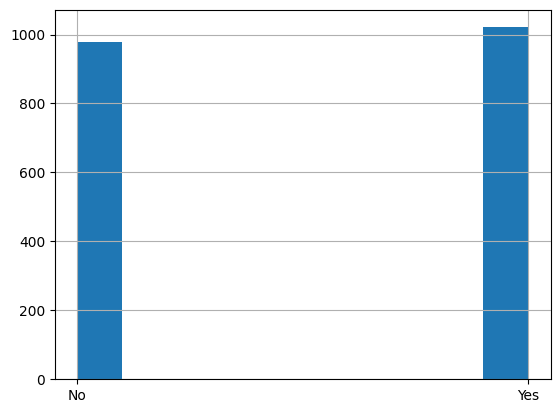

In [6]:
df_test["prediction"].hist()

In [7]:
import pandas as pd
from sklearn.metrics import f1_score

def clean_violates_rule(val):
    if isinstance(val, bool):
        return "Yes" if val else "No"
    if isinstance(val, str):
        val_clean = val.strip().strip('"').strip("'").capitalize()
        if val_clean in ["Yes", "No"]:
            return val_clean
    return "Unknown"  # or np.nan or keep as-is depending on your needs

df_test["violates_rule"] = df_test["violates_rule"].apply(clean_violates_rule)


# Normalize violates_rule to Yes/No
df_test["violates_rule"] = df_test["violates_rule"].map({True: "Yes", False: "No", "Yes": "Yes", "No": "No"})

# Compute F1 score (convert Yes/No to 1/0)
y_true = df_test["violates_rule"].map({"Yes": 1, "No": 0})
y_pred = df_test["prediction"].map({"Yes": 1, "No": 0})

f1 = f1_score(y_true, y_pred)

print("F1-score:", f1)


F1-score: 0.9866402770905492
